### Complete, not optimized and general implementation of Shor's algorithm

Here, we will see a fully detailed implementation of the Shor algorithm. This is done only for learning purposes, so it will not be optimized and use the best implementation, but will be fully functionnal on the simulator and technically on real quantum devices (provided there is enough qubits of course, which is not the case). However, it is very unlikely any current real hardware will be able to handle such long algorithm (it is really not optimized).

Because we want the code to be usable by the real devices, we can't use some of the tricks used in recent algorithms, involving measure feedback or qubit reseting. However, it won't use any a priori knowledge on the number $N$ we want to factorize, so it will be completly general and work on any number (with big enough hardware). With today's public hardware we can factorize $15=3\times 5$ on the 32 qubits simulator (we need 25 qubits).

#### Starting with the classical period finding

To begin with, the Shor algorithm is mainly classical. Here is an implementation of it. The explication is inside the code so please read it.

In [1]:
import random as r
import numpy as np

def powmod(a, p, n):
    """A**p%n, done in an inefficient way"""
    res = 1
    for _ in range(p):
        res = (res * a) % n
    return res

def periodfinder(A, n):
    """The algorithm to find the period in the modular exponentiation."""
    res = 1
    fun = A
    while fun != 1:
        fun = (fun * A) % n
        res += 1
    return res

def shor(n):
    """The global algorithm to find the factorization of n into its prime components."""
    print("Starting...")
    # A random integer is picked
    A = r.randrange(2, n)
    print("A:", A)
    # If we're lucky it's already the prime number or a multiple of it
    res = np.gcd(A, n)
    if res != 1:
        print("Lucky find!")
        return res, n // res
    # Start of the period finder procedure
    res = periodfinder(A, n)
    print("Res:", res)
    # end
    if res % 2:  # Unlucky, we have to pick an other A and redo everything
        print("Period not even...")
        return shor(n)
    else:
        L = res // 2
        R = powmod(A, L, n)
        if R == 1 or R + 1 == n:
            print("Trivial root...")
            return shor(n)
        P = np.gcd(R - 1, n)
        print("Result found!")
        return P, n // P

To keep it simple, the modular exponentiation function doesn't use the fast version of the algorithm, but it's okay, we won't factorize big numbers with the classical algorithm. We can test it by multiplying our favorite prime numbers.

In [2]:
shor(1789*1993)

Starting...
A: 2175464
Res: 296808
Result found!


(1789, 1993)

#### Quantum idea

The part we can exponentially accelerate is the period finding. Because we can do Fourier transform on quantum states, we can detect patterns. And we know the modular exponentiation $A^x\mod N$ is periodic, so it will have repeating values. This is the main goal of the quantum algorithm. 

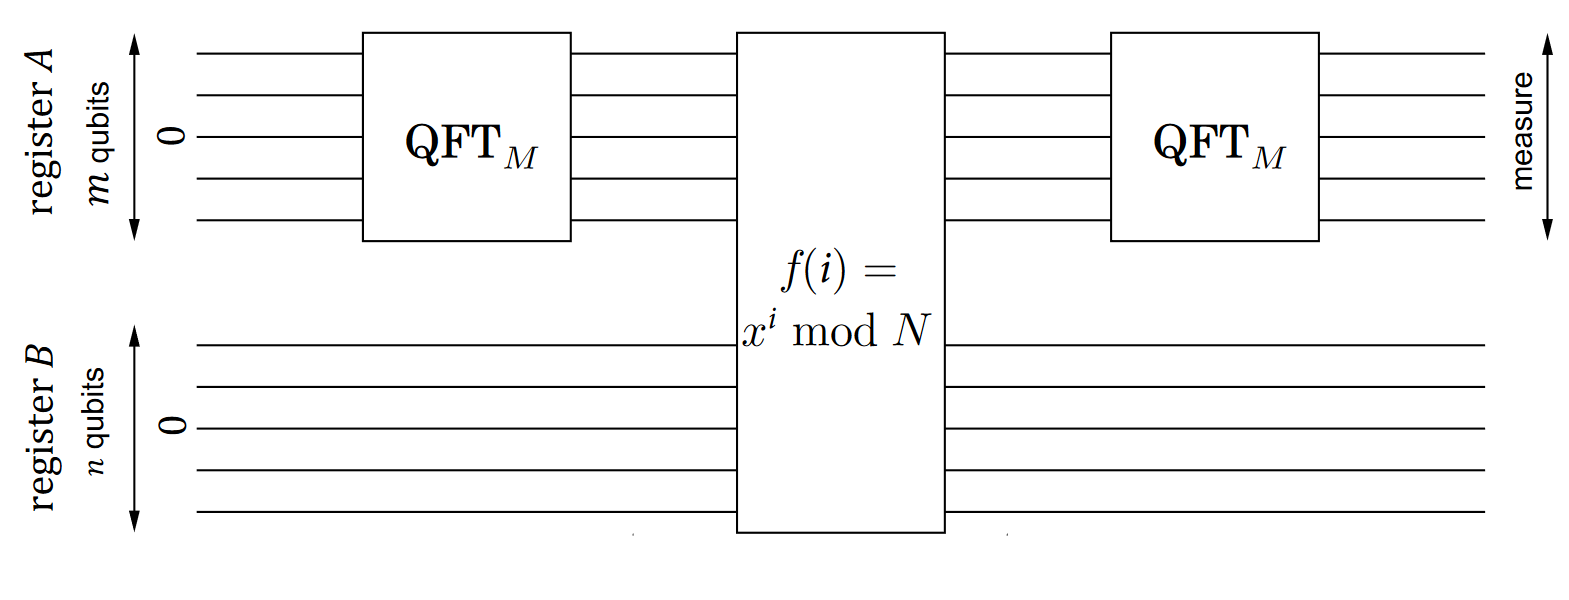

Create a superposition of all possible configuration for $x$, then feed it into a component that takes a qubit register containing the (supeposition of the) exponent, and an other initialized at zero for the result, and gives back the exponent and put the (superposition of the) result in the other, and then do a Quantum Fourier Transform on the exponent register to have remaining only the ones multiples of $\frac{M}{r}$, with $M=2^m$ the maximum exponent $x$ and $r$ the period we want to find. 

The biggest $M$ the better, because we measure $S$, the closest integer to $k\frac{M}{r}$. So, in order to find $r$, we can apply a classical algorithm on $\frac{S}{M}=\frac{k}{r}\pm\frac{1}{2M}$, which returns both $k$ and $r$ if $k$ is not a divisor of $r$ (or share any divisor with $r$), and if the error term $\pm\frac{1}{2M}$ isn't too big. In fact let $n\in \mathbb{N},\ 2^{n}\leq N=PQ<2^{n+1}$ the number of bits of the integer $N$ we want to factorize, then we want $n<2m$. 

So, the big work here is to generate, for a given number, the quantum component, *i.e.* the succession of quantum gates, that does the modular exponentiation.

For this, we won't use the best algorithm, because again this is for learning purposes, so it will be way too long for a basic quantum computer to use, but it will give an idea of what are the key points computer scientists are trying to improve. The best way to see the problem is to test.

#### Modular exponentiation

The base of all arithmetic operation is the addition. We will implement the adder from [this paper](https://arxiv.org/abs/quant-ph/0410184v1):
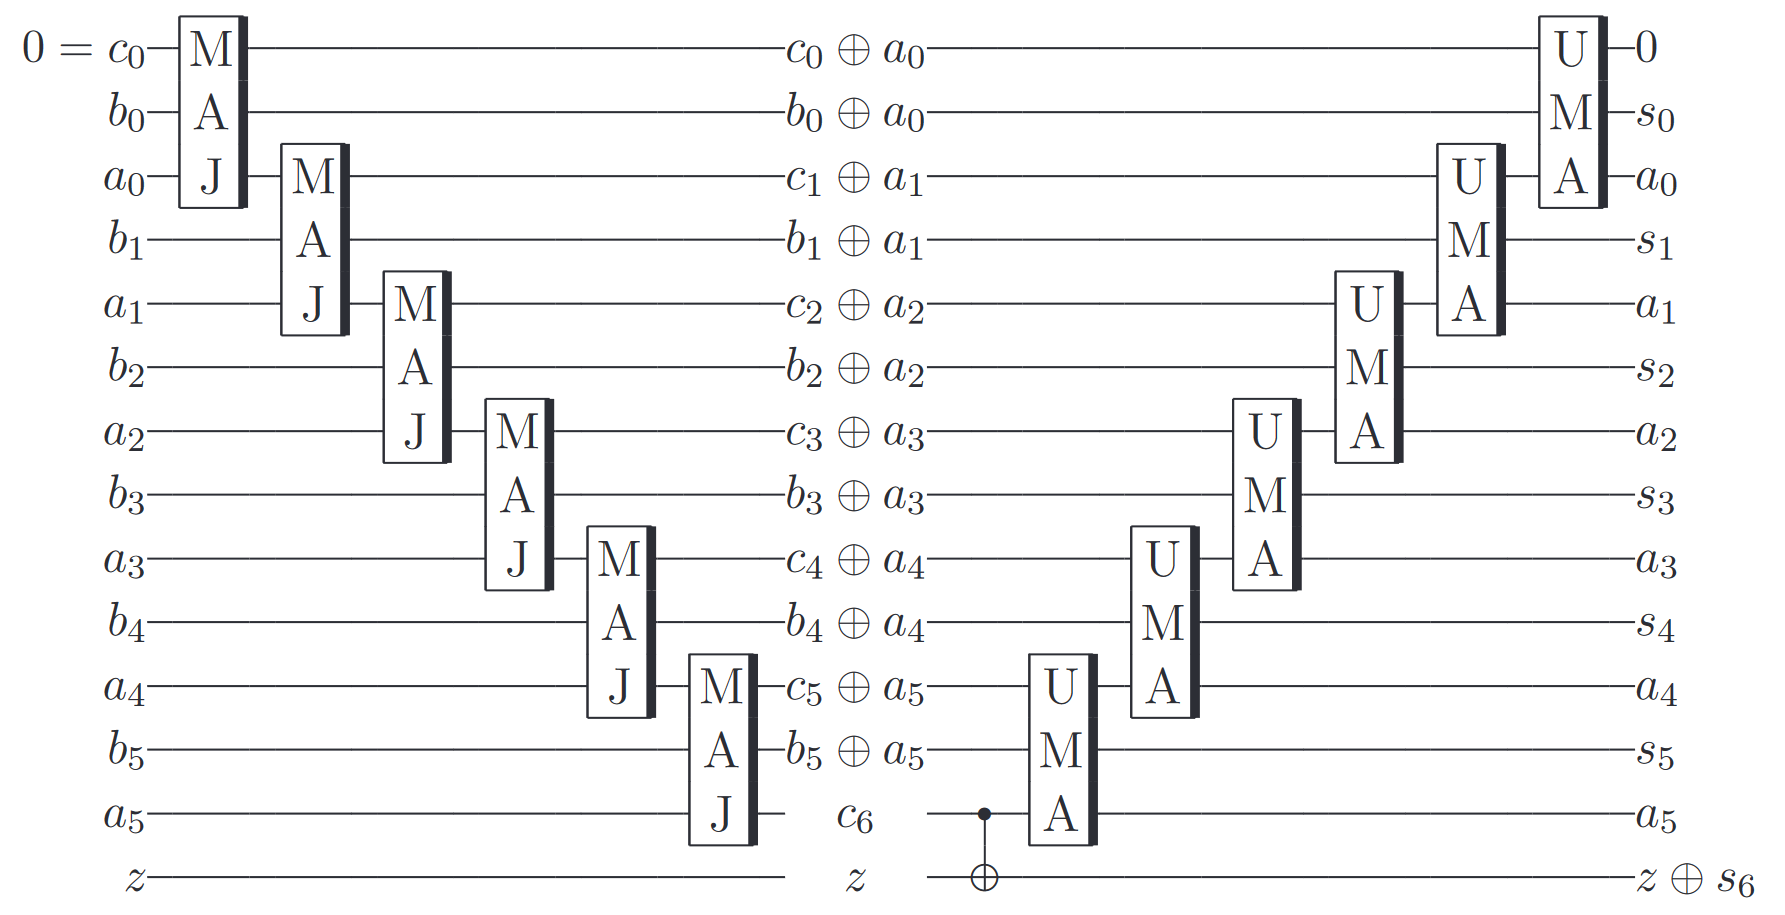

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer

In [4]:
def MAJ(circ, q, c, b, a):
    """A part of the adder"""
    circ.cx(a, b)
    circ.cx(a, c)
    circ.ccx(b, c, a)
    
def UMA_3(circ, q, c, b, a):
    """A part of the adder, an other version with more gates but less depth"""
    circ.x(b)
    circ.cx(c, b)
    circ.ccx(c, b, a)
    circ.x(b)
    circ.cx(a, c)
    circ.cx(a, b)

def add_o(circ, q, A, B, lost, last):
    """A and B are lists of the qbits of a and b to be added, lost is ancilla.
     A->A B->A+B. Last is the eventual carry, so the result is in B+[last].
     This version uses more gates but less depth, so is faster"""
    if len(A) < 4:
        MAJ(circ, q, lost, B[0], A[0])
        for i in range(1, len(A)):
            MAJ(circ, q, A[i - 1], B[i], A[i])
        circ.cx(A[-1], last)
        for i in range(len(A) - 1, 0, -1):
            UMA_3(circ, q, A[i - 1], B[i], A[i])
        UMA_3(circ, q, lost, B[0], A[0])
        # now a=a and b = b+a
    else:
        n = len(A)
        for i in range(1, n):
            circ.cx(A[i], B[i])
        circ.cx(A[1], lost)
        circ.ccx(A[0], B[0], lost)
        circ.cx(A[2], A[1])
        circ.ccx(lost, B[1], A[1])
        circ.cx(A[3], A[2])
        for i in range(2, n-2):
            circ.ccx(A[i-1], B[i], A[i])
            circ.cx(A[i+2], A[i+1])
        circ.ccx(A[n-3], B[n-2], A[n-2])
        circ.cx(A[n-1], last)
        circ.ccx(A[n-2], B[n-1], last)
        for i in range(1, n-1):
            circ.x(B[i])
        circ.cx(lost, B[1])
        for i in range(2, n):
            circ.cx(A[i-1], B[i])
        circ.ccx(A[n-3], B[n-2], A[n-2])
        for i in range(n-3, 1, -1):
            circ.ccx(A[i-1], B[i], A[i])
            circ.cx(A[i + 2], A[i+1])
            circ.x(B[i+1])
        circ.ccx(lost, B[1], A[1])
        circ.cx(A[3], A[2])
        circ.x(B[2])
        circ.ccx(A[0], B[0], lost)
        circ.cx(A[2], A[1])
        circ.x(B[1])
        circ.cx(A[1], lost)
        for i in range(n):
            circ.cx(A[i], B[i])

As explained in the code, this adder is the shorter implementation of the paper, which uses more gates but is more compact. This is why the implementation is a bit long, but it follows a precise construction:
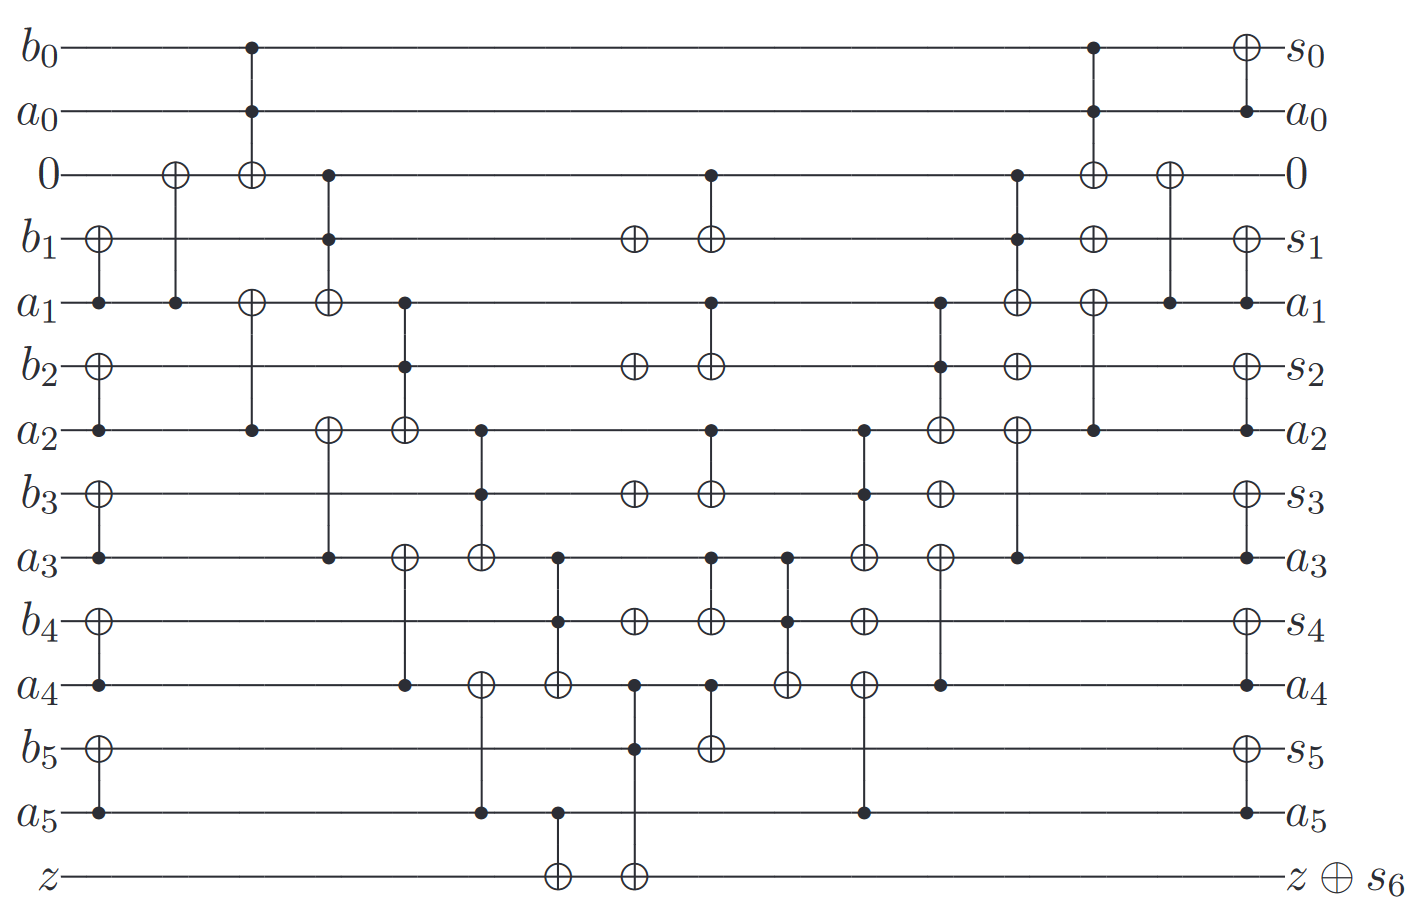

With this, we can do everything! First, we will need the substraction (or more precisely the inverse of this adder).

In [5]:
def sub_o(circ, q, A, B, lost, last):
    """A and B are lists of the bits of a and b to be added, lost is ancilla.
         A->A A+B->B. Last is the eventual carry, so the result is in B+[last].
         This version uses more gates but less depth, so is faster"""
    if len(A) < 4:
        AMU_3(circ, q, lost, B[0], A[0])
        for i in range(1, len(A)):
            AMU_3(circ, q, A[i - 1], B[i], A[i])
        circ.cx(A[-1], last)
        for i in range(len(A) - 1, 0, -1):
            JAM(circ, q, A[i - 1], B[i], A[i])
        JAM(circ, q, lost, B[0], A[0])
    else:
        n = len(A)
        for i in range(n-1, -1, -1):
            circ.cx(A[i], B[i])
        circ.cx(A[1], lost)
        circ.x(B[1])
        circ.cx(A[2], A[1])
        circ.ccx(A[0], B[0], lost)
        circ.x(B[2])
        circ.cx(A[3], A[2])
        circ.ccx(lost, B[1], A[1])
        for i in range(2, n-2):
            circ.x(B[i + 1])
            circ.cx(A[i + 2], A[i + 1])
            circ.ccx(A[i - 1], B[i], A[i])
        circ.ccx(A[n - 3], B[n - 2], A[n - 2])
        for i in range(n-1, 1, -1):
            circ.cx(A[i - 1], B[i])
        circ.cx(lost, B[1])
        for i in range(n - 2, 0, -1):
            circ.x(B[i])
        circ.ccx(A[n - 2], B[n - 1], last)
        circ.cx(A[n - 1], last)
        circ.ccx(A[n - 3], B[n - 2], A[n - 2])
        for i in range(n-3, 1, -1):
            circ.cx(A[i + 2], A[i + 1])
            circ.ccx(A[i - 1], B[i], A[i])
        circ.cx(A[3], A[2])
        circ.ccx(lost, B[1], A[1])
        circ.cx(A[2], A[1])
        circ.ccx(A[0], B[0], lost)
        circ.cx(A[1], lost)
        for i in range(n-1, 0, -1):
            circ.cx(A[i], B[i])

This is not really a substraction, it is the reverse addition, so any negative result will be the number such that the adder would have given the entry. It is mainly used to reset register.

Then, we want to do addition modulo anything. For this, we will implement [this paper](https://arxiv.org/abs/quant-ph/9511018v1).
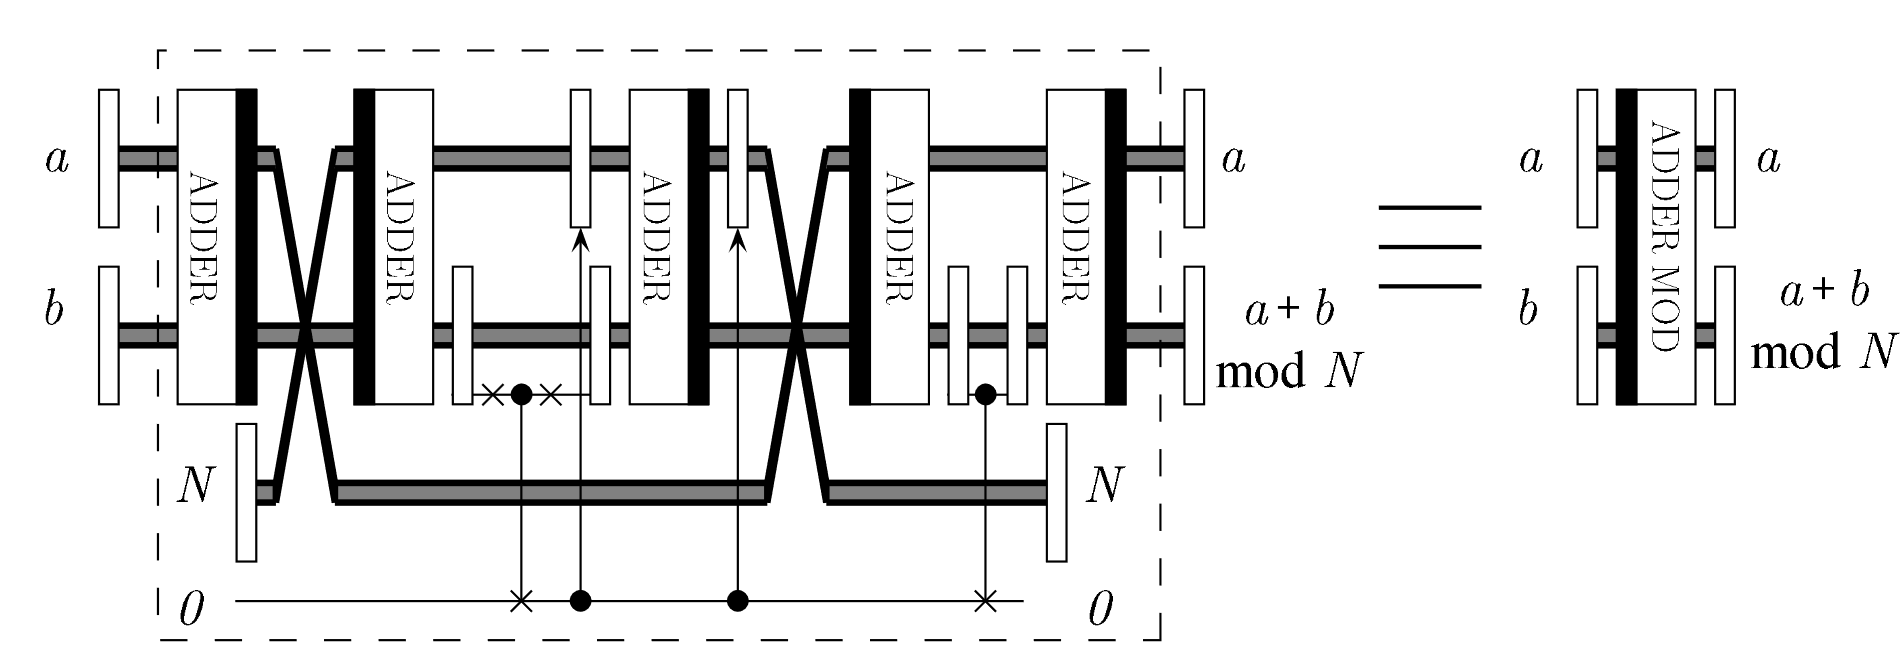

We can see the begining of the depth problem: each modular addition calls five additions (or reverse addition), and we want to exponentiate, so there will be a lot of modular additions.

Anyway, we can code the function that takes all the qubits registers needed and will add a modular adder on the circuit given. Keep in mind this is presentation code so it is not well defended against bad inputs.

In [6]:
def addmod(circ, q, A, B, lost, last, N, lost2, binn):
    """The modular addition. A and B are lists of the bits of a and b to be added, N the modulo, a+b<2N,
    lost is ancilla. A->A B->B+A mod N. Last is the eventual carry, so the result is in B+[last]."""
    # A + B
    add_o(circ, q, A, B, lost, last)
    # A+B-N
    sub_o(circ, q, N, B, lost, last)
    # We check if A+B-N<0
    circ.x(last)
    circ.cx(last, lost2)
    circ.x(last)
    # if yes, we do:
    # control swap N to 0
    for i in range(len(binn)):
        if binn[i]:
            circ.cx(lost2, N[i])
    # A+B-N+(N if A+B-N<0 else 0)=A+B (-N if not negative) (<N so no modulo to be applied)
    add_o(circ, q, N, B, lost, last)
    # control swap 0 to N
    for i in range(len(binn)):
        if binn[i]:
            circ.cx(lost2, N[i])
    # And we do it again to reset the lost qbit
    sub_o(circ, q, A, B, lost, last)
    circ.cx(last, lost2)
    add_o(circ, q, A, B, lost, last)


def submod(circ, q, A, B, lost, last, N, lost2, binn):
    """The modular addition inverse. A and B are lists of the bits of a and b to be added, N the modulo, a+b<2N,
    lost is ancilla. A->A A+B mod N->B. Last is the eventual carry, so the result is in B+[last].
    It is just the addition in reverse order"""
    sub_o(circ, q, A, B, lost, last)
    circ.cx(last, lost2)
    add_o(circ, q, A, B, lost, last)
    for i in range(len(binn) - 1, -1, -1):
        if binn[i]:
            circ.cx(lost2, N[i])
    sub_o(circ, q, N, B, lost, last)
    for i in range(len(binn) - 1, -1, -1):
        if binn[i]:
            circ.cx(lost2, N[i])
    circ.x(last)
    circ.cx(last, lost2)
    circ.x(last)
    add_o(circ, q, N, B, lost, last)
    sub_o(circ, q, A, B, lost, last)

We defined both modular addition and inverse addition. We see here that the algorithm uses one additional register for $N$ and one additional ancilla qubit which is just a "catalyser": it is both zero when entering and exiting the circuit. The three registers must have the same size, and $N$ will be the final $N=PQ$, so we can already estimate the current qubit usage: $3n+3$ (three registers of size $n$, two ancillas and a carry qubit), and the depth, given an addition takes $2n+4$ time steps: the modular adder takes $5(2n+4)+6$ time steps.



Next step is the multiplication. Intuitively, we know that, because $a\times b=a+a+\dots+a$, $b$ times, we will have to iterate on one of the numbers given. But, because the numbers are in binary, we will just use the fact that $a\times b=\sum\limits_i ab_i2^i$, where $b_i$ is the $i$-th bit of $b$. 
However, for the multiplication to be useful, we will need it to be controlled. It will take two registers A and B and one control qubit and put $a\times b \mod N$ in B if control is one, $a$ else. This is what is presented in this circuit. It is explained in more details in the code and below.

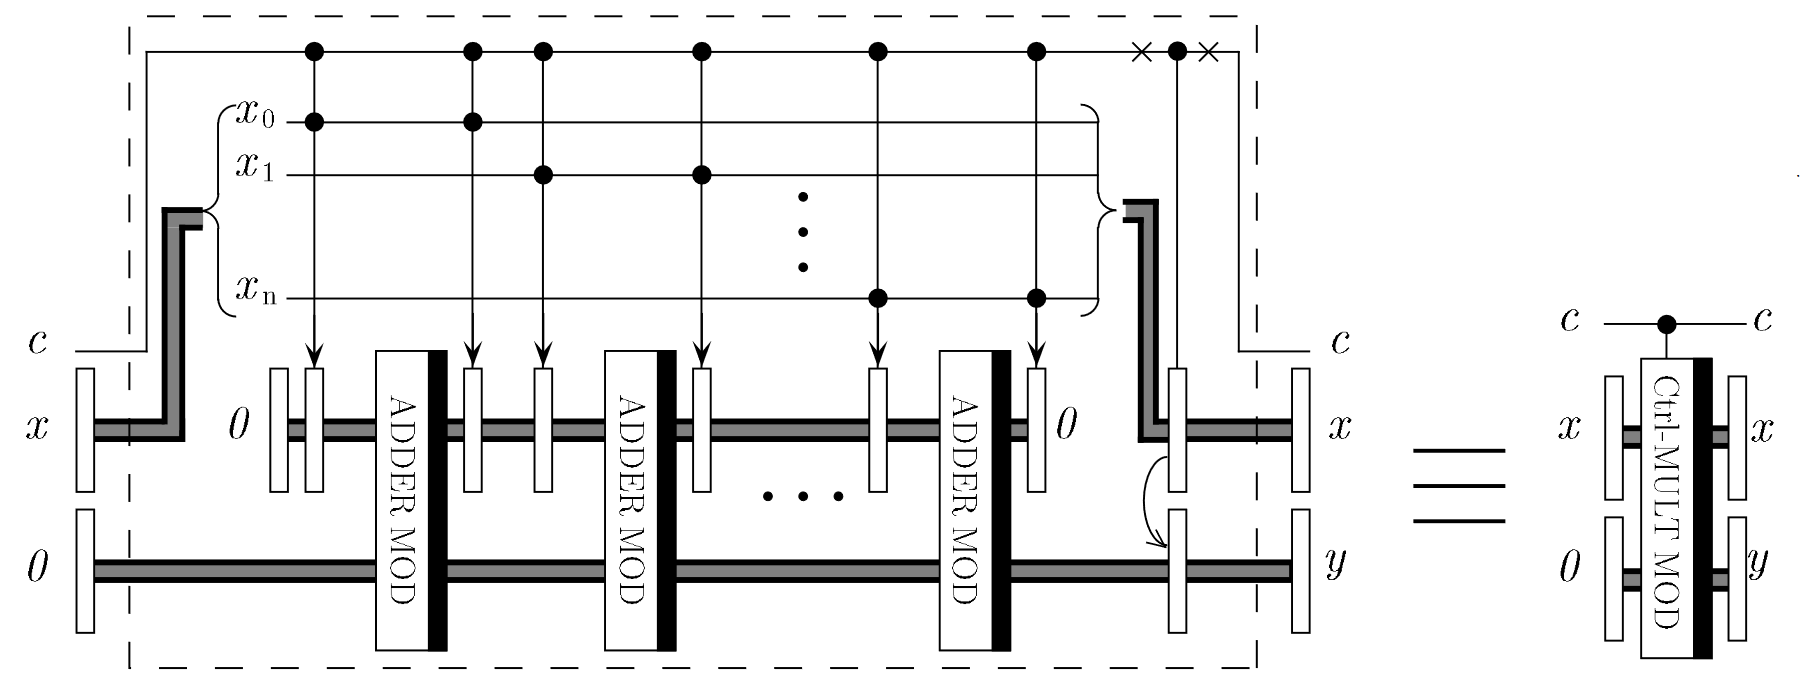

In [7]:
def cmultmod(circ, q, control, X, a, A, Y, n, N, binn, lost, lost2):
    """control the control qbit, X the list of qbits of b, bina the bitlist of a,
    A the list of qbits (at zero) with enough place to put a, Y the res register,
    N the modulo register, binn its bitlist and lost and lost2 two ancillas
    X->X Y->b*y if control else 0 A=0->0 N=0->0"""
    # We have to precompute the different a*2**i to be added if b_i
    binapow = [[int(x) for x in bin((powmod(2, i, n) * a) % n)[2:]] for i in range(len(X))]
    for i in range(len(binapow)):
        binapow[i].reverse()
    # For each bit in X
    for i in range(len(X)):
        # We conditionally load a*2**i%n in A for the addition. if not control, it will be 0
        for j in range(len(binapow[i])):
            if binapow[i][j]:
                circ.ccx(control, X[i], A[j])
        # We add either 0 or a*2**i%n depending on control and the i-th bit of X
        addmod(circ, q, A, Y, lost, Y[-1], N, lost2, binn)
        # We unload what was in A
        for j in range(len(binapow[i])):
            if binapow[i][j]:
                circ.ccx(control, X[i], A[j])
    # if not control, we load X in Y because it would be empty
    circ.x(control)
    for i in range(len(X)):
        circ.ccx(control, X[i], Y[i])
    circ.x(control)
    # note that for it to work, Y need to be empty at the start
    # A=0->0;X->X,Y=0->X if not control else x*a, N->N
    
def cdivmod(circ, q, control, X, a, A, Y, n, N, binn, lost, lost2):
    """The reverse multiplication. control the control qbit, B the list of qbits of b, bina the bitlist of a,
    A the list of qbits (at zero) with enough place to put a, Y the res register,
    N the modulo register, binn its bitlist and lost and lost2 two ancillas
    B->B b*y mod N->Y if control else 0 A=0->0 N=0->0"""
    binapow = [[int(x) for x in bin((powmod(2, i, n) * a) % n)[2:]] for i in range(len(X))]
    for i in range(len(binapow)):
        binapow[i].reverse()
    circ.x(control)
    for i in range(len(X) - 1, -1, -1):
        circ.ccx(control, X[i], Y[i])
    circ.x(control)
    for i in range(len(X) - 1, -1, -1):
        for j in range(len(binapow[i]) - 1, -1, -1):
            if binapow[i][j]:
                circ.ccx(control, X[i], A[j])
        submod(circ, q, A, Y, lost, Y[-1], N, lost2, binn)  # Y may be too long?
        for j in range(len(binapow[i]) - 1, -1, -1):
            if binapow[i][j]:
                circ.ccx(control, X[i], A[j])


We see that, this time, the way it uses the registers is different. We dont have A and B two registers containing the numbers to be multiplied, but A empty with sufficient size, and the value $a$ to precompute the successive $a2^i$. The idea is to do successive additions between the previous result (starting at zero), and either 0 or $1\times a2^i$ if both the control qubit and the $i$-th bit of b is 1. The result will be in a new register named Y. 



So at this moment we need four registers of size $n$: A (empty), B (containing $b$), Y (empty then containing the result) and N (contains $N$). That's $4n+3$ qbits, without the control qbit (it doesn't represent a real value for now). And each multiplication requires $n$ modular additions, $2n$ value input in register A (putting $a2^i$ then removing it, for each bit of B), then one extra check to put $b$ in Y if not control, taking $n+2$ gates. That's $n(5(2n+4)+6)+n(2n)+n+2=n(12n+27)+2$ time steps.

Finally, we can build the modular exponentiation! The idea is the same as the multiplication: we will do successive multiplication (starting by 1 and not 0 this time, of course) of $a^{2^i}$, because  $a^x \mod N = \prod\limits_i a^{2^i x_i}\mod N$. That's why we needed controlled multiplication, to have the multiplication done only if $x_i$ is 1. The only issue is that, because the multiplication needs an empty register to correctly function, we need to reset it each time, so for each bit of X (the exposant), we will need to do two multiplication, and switch two registers.

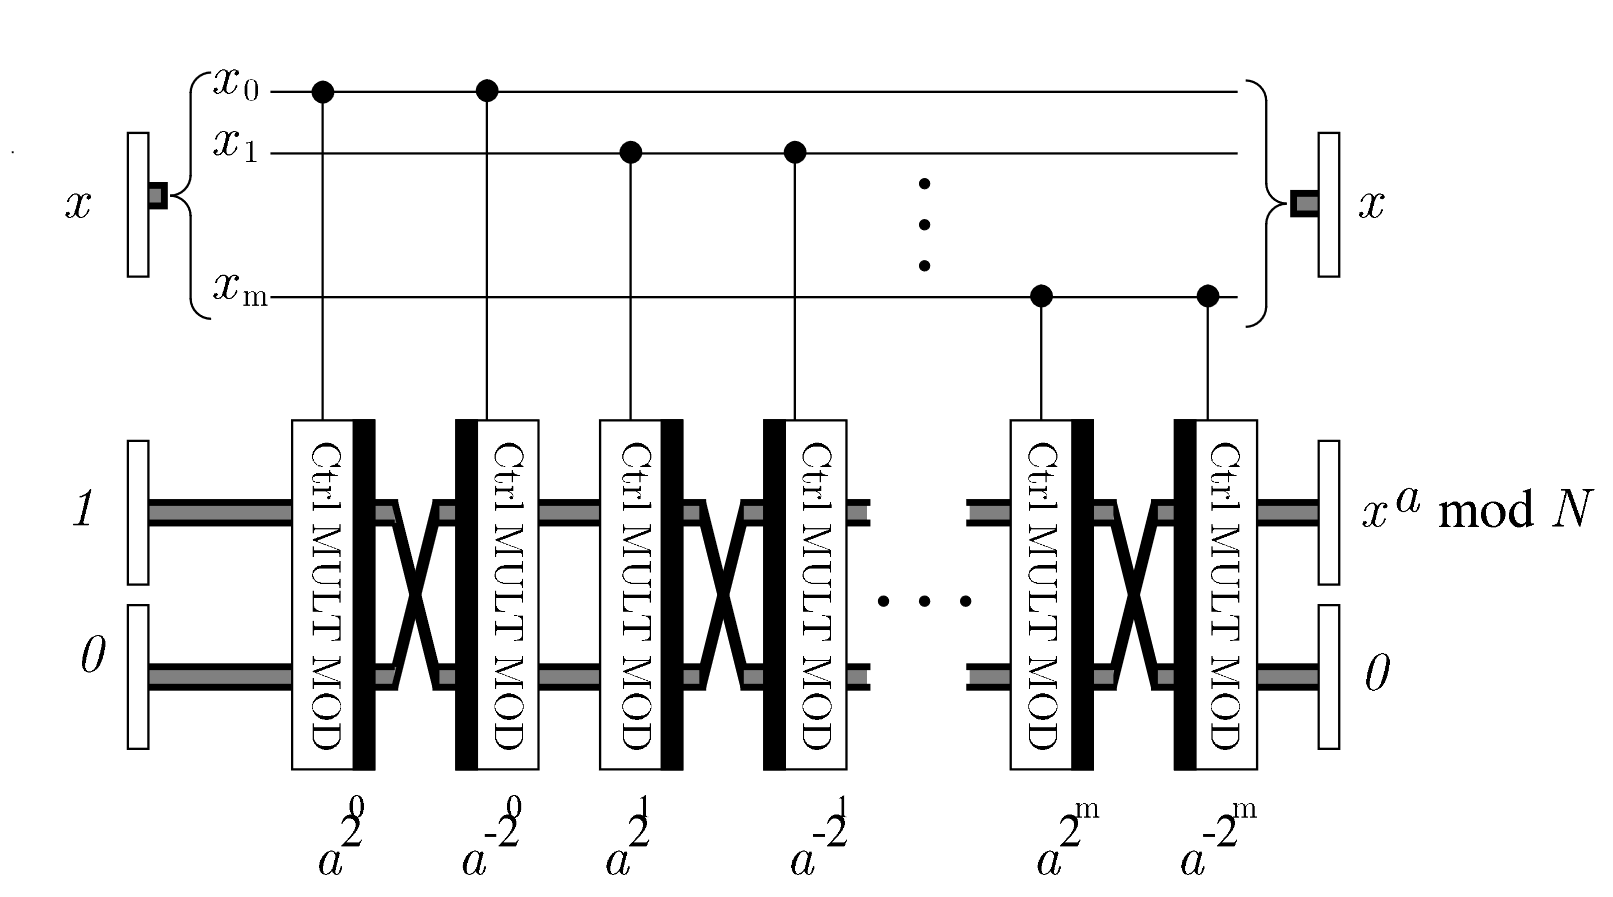

In [8]:
def expmod(circ, q, X, a, A, APOW, Y, n, N, binn, lost, lost2):
    """The modular exponentiation. X is the list of bits of x such that we want a**x mod n. A has to be big enough
    to contain n (it will contain a*2**i%n), APOW is the same (it will contain a**(2**i)%n), Y is the same plus one,
    (it will contain the result at the end), n is the value of the modulo, N its register, binn its bitlist, and
    lost and lost2 two ancillas"""
    # We initialize APOW at 1 (start of successive multiplications)
    circ.x(APOW[0])
    # For each bit in X (the exposant)
    for i in range(len(X)):
        # We do a controlled multiplication if x_i
        control = X[i]
        # Here APOW cointains a**(x_0*2**0)*a**(x_1*2**1)*...*a**(x_k*2**k)%N and Y = 0
        cmultmod(circ, q, control, APOW, powmod(a, 2 ** i, n), A, Y, n, N, binn, lost, lost2)
        # Here APOW cointains a**(x_0*2**0)*a**(x_1*2**1)*...*a**(x_k*2**k)%N and
        # Y = a**(x_0*2**0)*a**(x_1*2**1)*...*a**(x_k*2**k)*a**(x_{k+1}*2**(k+1))%N
        # We switch APOW and Y
        temp = APOW.copy()
        APOW = Y[:-1]
        Y = temp + [Y[-1]]
        # We reset Y (containing the previous step)
        # Here APOW cointains a**(x_0*2**0)*a**(x_1*2**1)*...*a**(x_k*2**k)*a**(x_{k+1}*2**(k+1))%N and
        # Y = a**(x_0*2**0)*a**(x_1*2**1)*...*a**(x_k*2**k)%N
        cdivmod(circ, q, control, APOW, powmod(inversemod(a, n), 2 ** i, n), A, Y, n, N, binn, lost, lost2)
        # Here APOW cointains a**(x_0*2**0)*a**(x_1*2**1)*...*a**(x_k*2**k)*a**(x_{k+1}*2**(k+1))%N and Y = 0
        # Ready to loop again!

    return 1

So we have everything! We finally need four registers of size $n$ (A, APOW, Y and N), to store respectively the values necessary to do the multiplication (the A of the multiplier code section), the values to be multiplied (the X of the multiplier code section), the result (the Y of the multiplier code section), and the modulo. We also need an extra register as big as possible (bigger than $2n$), to store the exposant, it's the X (control of the multiplier code section). So we need $4n+3+m>6n+3$ qubits for the Shor algorithm to work, using $2m$ multiplication (2 by bit of X), $m$ being the size of X. 

In total that's $2m(n(12n+27)+2)=24mn^2+54mn+2m>48n^3+108n^2+4n$ time steps, counting Toffoli's gates as one time step (which is unaccurate). So this is an underestimation of the real depth, but close enough to give an idea of the issue here. However, this is completely general, no assumption is made on the number $a$ or $N$ given, so given a perfect quantum computer, we could directly run this code and break RSA.

#### Putting together everything

To finish the implementation, we will add some functions to help the developpement of the actual qperiod finder.

In [13]:
# Two tools to run and then compute the period 
def inversemod(a, n):
    """Calculates b, a*b = 1 mod N"""
    b = n
    a, sa = abs(a), -1 if a < 0 else 1
    b, sb = abs(b), -1 if b < 0 else 1
    vv, uu, v, u = 1, 0, 0, 1
    e = 1
    q, rr = divmod(a, b)
    while rr:
        a, b = b, rr
        vv, v = q * vv + v, vv
        uu, u = q * uu + u, uu
        e = -e
        q, rr = divmod(a, b)
    res = -sa * e * uu
    return res if res > 0 else n + res

def fracf(N, S):
    """We suppose S = k*N/L. Return k,L. Ex: N=10000, S = 66667, res = 1,3"""
    L = [N, S]
    Lneg = [-S]
    T = []
    while L[-1] > 10 and -Lneg[-1] > 10:
        L.append(L[-2] % L[-1])
        T.append(L[-3] // L[-2])
        Lneg.append((L[-3] % L[-2]) - L[-2])
        print(L, T, Lneg)
    Backtrack = [(T[-1]+1*(Lneg[-1]>-10)), 1]
    for i in range(len(T)-1):
        Backtrack = [T[-2-i]*Backtrack[0]+Backtrack[1]]+Backtrack
    print(Backtrack)
    return Backtrack[1], Backtrack[0]

#The Quantum Fourier Transform
def QFTn(circ, q, X):
    """A strange QFT but it works"""
    lamb = [2 * np.pi / (2 ** m) for m in range(2, len(X) + 1)]
    X.reverse()
    for i in range(len(X)):
        circ.h(X[i])
        for j in range(len(lamb) - i):
            circ.cu1(lamb[j], X[1 + j + i], X[i])
    return 1

In [10]:
#Quality of life function
def measure_direct(circ, reg, targ):
    """Returns circ with measures added on reg on each qbit index specified in targ"""
    c = ClassicalRegister(len(targ), 'c')
    meas = QuantumCircuit(reg, c)
    for i in range(len(targ)):
        meas.measure(targ[i], c[i])
    return circ + meas

#Redefine period finder
def periodfinder(A, n):
    """The algorithm to find the period in the modular exponentiation. Makes a call to the quantum algorithm but
    can switch back to classical algorithm if it fails"""
    prop = qperiodfinder(A, n)  # Quantum period finder, can fail
    if prop:  # No apriori failure
        res = prop
        Aprop = powmod(A, prop, n)  # Eventuellement on ne fait pas cette verification et on test tout à la fin
        fun = Aprop
        if fun != 1:
            print("Quantum process failed, surely because k|L. Back to classical.")
        while fun != 1:  # Maybe infinite loop, if quantum completely failed
            fun = (fun*Aprop) % n
            res += prop
        return res
    # Quantum process failed, classical algorithm
    res = 1
    fun = A
    while fun != 1:
        fun = (fun * A) % n
        res += 1
    return res

#the quantum part of it: creates the ciruit and runs it on the simulator
def qperiodfinder(A, n):
    """The quantum algorithm to find the period in the modular exponentiation"""
    maxQ = 25  # Here we set the number of qbits we have available
    circ_m = shor_quant(A, n, maxQ)  # The quantum circuit is generated
    if circ_m is 0:
        print("Quantum circuit generation failed. Classical circuit engaged")
        return 0
    print("Quantum circuit generated...")
    print("Total Qbit usage:{}, Total depth: {}".format(circ_m.width(), circ_m.depth()))
    #Call to the simulator
    name = 'ibmq_qasm_simulator'
    backend_sim = IBMQ.get_backend(name, hub=None)  # BasicAer.get_backend('qasm_simulator')
    print("Sending quantum circuit to hardware "+name+", waiting for the result...")
    job_sim = execute(circ_m, backend_sim, shots=1, max_credits=3)
    result_sim = job_sim.result()
    print("Result get!")
    counts = result_sim.get_counts(circ_m)
    print(counts, type(counts))
    bits_N = len(bin(n)) - 2
    bits_X = maxQ - 4 * (bits_N + 1) + (maxQ - 4 * (bits_N + 1)) % 2
    for key in counts:
        print(key)
        print(type(key))
        S = int('0b' + key[bits_N:], 2)  # S = int(k*2**bits_X/L), we want to find L with it. It can fail if k|L
        # here N is not the number we ant to factorize, it's 2**bits_X,
        # the "magnitude" of our period fider algorithm
        N = 2 ** bits_X
        print("S:", S, "M:", N)
        # Call to the fraction finder, given N and S = k*N/L, will return (k, L), as a simplified fraction.
        k, L = fracf(N, S)
        print(k, L)
    return L

def shor_quant(A, N, maxQ):
    """Builds the quantum circuit for the period estimation part of shor.
    maxQ is the size limit of the computer"""
    binn = [int(x) for x in bin(N)[2:]] # The binlist of N
    binn.reverse()
    bits_N = len(binn)  # number of bits of N
    bits_X = maxQ - (4 * bits_N + 3) - (maxQ - (4*bits_N + 3)) % 2  # number of bits of X, must be even
    print("Qbits for N:", bits_N)
    print("Qbits for X:", bits_X)
    if bits_X < 1 * bits_N:  # here we don't want to send requests when the result won't be satisfying
        print("Not enough qbits")
        return 0
    print("Launching quantum procedure...")
    # Dans l'ordre:X(m)|Y(n+1)|N(n)|A(n)|APOW(n)|lost|lost2
    # nombre total de qbits: 7*n+3+1*(3*n%2)

    nX = bits_X  # q[nX] debut de Y
    nXY = nX + bits_N + 1  # q[nXY] debut de N
    nXYN = nXY + bits_N  # q[nXYN] debut de A
    nXYNA = nXYN + bits_N  # q[nXYNA] debut de APOW
    n = nXYNA + bits_N  # Total de qbit chargés

    q = QuantumRegister(n + 2, 'q')  # +lost+lost2=+2
    circ = QuantumCircuit(q)

    # We have all the quantum registers of qbits.

    RegX = [q[i] for i in range(bits_X)]
    RegY = [q[i + nX] for i in range(nXY - nX)]
    RegN = [q[i + nXY] for i in range(nXYN - nXY)]
    RegA = [q[i + nXYN] for i in range(nXYNA - nXYN)]
    RegAPOW = [q[i + nXYNA] for i in range(n - nXYNA)]

    # Uniform superposition on X
    for r in RegX:
        circ.h(r)
    # Setting of N
    for r in [RegN[i] for i in range(bits_N) if binn[i]]:
        circ.x(r)  # Set N

    # Main call: the modular exponentiation

    expmod(circ, q,
           RegX,  # X
           A,  # a
           RegA,  # A
           RegAPOW,  # APOW
           RegY,  # Y
           N,  # n
           RegN,  # N
           binn,  # binn
           q[n],  # lost
           q[n + 1])  # lost2

    # Comme bits_X est pair, le resultat A**x%n est dans RegAPOW

    # Reset of N to 0 (useless here)
    for r in [RegN[i] for i in range(bits_N) if binn[i]]:
        circ.x(r)  # Reset N

    QFTn(circ, q, RegX)  # Fourier transform de X
    circ_m = measure_direct(circ, q, RegX + RegY)

    return circ_m

#redefinition of shor with quantum part
def shor(n):
    """The global algorithm to find the factorization of n into its prime components."""
    print("Starting...")
    # A random integer is picked
    A = 13# We force 13 otherwise it would not be interesting
    print("A:", A)
    # If we're lucky it's already the prime number or a multiple of it
    res = np.gcd(A, n)
    if res != 1:
        print("Lucky find!")
        return res, n // res
    # Start of quantum procedure
    res = periodfinder(A, n)
    print("Res:", res)
    # fin
    if res % 2:  # Unlucky, we have to pick an other A and redo everything
        print("Period not even...")
        return shor(n)
    else:
        L = res // 2
        R = powmod(A, L, n)
        if R == 1 or R + 1 == n:
            print("Trivial root...")
            return shor(n)
        P = np.gcd(R - 1, n)
        print("Result found!")
        return P, n // P

We have redefined the two previous Shor functions to add the quantum part. The main function qperiodfinder creates the circuit (call to shor_quant), and then runs it on the 32 qubits simulator. We can see we hard-coded the max number of qubits to be 25 because even the 32 qubits public simulator takes a lot of time to run the algorithm. We also fixed the number $A$ for which we want to find the modular period, because otherwise it wouldn't be interesting (either trivial period or a direct find).

Now it's done! We can run it, to factorize 15 using 25 qbits. 

In [11]:
from qiskit import IBMQ
IBMQ.load_accounts()

In [14]:
shor(15)

Starting...
A: 13
Qbits for N: 4
Qbits for X: 6
Launching quantum procedure...
Quantum circuit generated...
Total Qbit usage:25, Total depth: 3054
Sending quantum circuit to hardware ibmq_qasm_simulator, waiting for the result...
Result get!
{'00000010000': 1} <class 'dict'>
00000010000
<class 'str'>
S: 16 N: 64
[64, 16, 0] [4] [-16, -16]
[4, 1]
1 4
Res: 4
Result found!


(3, 5)

This algorithm is long (because it's run on a simulator that has to do all the linear algebra), and has chances to fail, for example if the measure $S=k\frac{M}{r}$ is such that $k|r$. Here that's not (exactly) the case, because $S=16$ so $\frac{S}{M} = \frac{1}{4}$, so $k=1$ and $r=4$. But it could have been $k=2$ and then we would have found $r=2$, the wrong result!

Here the fraction finder is not really usefull, because $r$ is a power of 2, so the $S$ is not an approximation ($k\frac{M}{r}$ is an integer so $S$ the closest integer is the exact result). But, in general, it is not likely to be the case. The function fracf can detect close simplified fraction, like if we give it 100000 and 66667, it will recognize the fraction $\frac{2}{3}$, but can't give $\frac{4}{6}$, so if $k=4$ and $r=6$, it would give the wrong answer.

One remark we can have is the depth of the circuit: a little bit over 3000. It's way too big for it to run on a quantum computer for now. But if we have access to a perfect quantum computer, we could theoretically run this exact code on it, which was the purpose of this little exercise. In fact we would never run such algorithm because it is heavily improvable (for example the X register can be reduced from $2n$ qubits minimum to only one qubit if we can do measure feedback), but it works and is understandable, which is already great given how complicated Shor algorithm sounds when hearing about it first.